In [1]:
library(dplyr)
library(tidyr)
library(tibble)
library(ggplot2)
library(stringr)
library(ggrepel)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
color_annotation<-read.csv('../Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

In [3]:
df <- read.csv("02_Freq_Changes_Y1D0//FreqChanges_and_DEG_Y1D0.csv")

In [4]:
df$AIFI_L3_label <- gsub("cell", "", df$AIFI_L3)
labels_vector<-c('Adaptive NK cell', 'GZMB- CD27+ EM CD4 T cell',
       'GZMK+ CD27+ EM CD8 T cell', 'KLRF1+ GZMB+ CD27- EM CD8 T cell',
       'KLRF1+ effector Vd1 gdT', 'KLRF1- GZMB+ CD27- EM CD8 T cell',
       'KLRF1- GZMB+ CD27- memory CD4 T cell', 'Proliferating T cell')

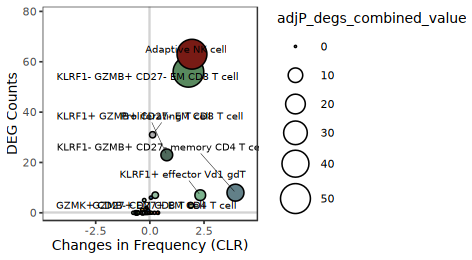

In [16]:
options(repr.plot.width = 100/25.4, repr.plot.height = 55/25.4)

df <- df %>% arrange(desc(adjP_degs_combined_value))
p <- ggplot(df, aes(x = delta_change, y = DEG_Counts, size = adjP_degs_combined_value, fill = AIFI_L3)) +
  geom_hline(yintercept = 0, color = "lightgray", size = 0.5) + 
  geom_vline(xintercept = 0, color = "lightgray", size = 0.5) + 
  geom_point(shape = 21, colour = "black") +
  theme_bw(base_size = 8) +
  scale_size_continuous(range = c(0, 8), limits = c(0, max(df$adjP_degs_combined_value))) +
  xlab("Changes in Frequency (CLR)") +
  ylab("DEG Counts") +
  theme(legend.position = "right") +
  scale_fill_manual(values = color_vector) +
  scale_x_continuous(limits = c(-4.5, 4.5)) +
  guides(fill = "none", size = guide_legend("adjP_degs_combined_value")) + 
  geom_text_repel(
    data = df %>% filter(AIFI_L3 %in% labels_vector),
    box.padding = 0.5,
    force = 0.5,
    max.overlaps = 50,
    nudge_x = 0.15,
    hjust = 0.1,
    segment.size = 0.1,
    mapping = aes(label = AIFI_L3),
    size = 2
  ) +
  theme(
    panel.grid.major = element_blank(),  # Remove major grid lines
    panel.grid.minor = element_blank()   # Remove minor grid lines
  )+
  scale_y_continuous(expand = expansion(mult = c(0.05, 0.3)))

print(p)
ggsave('FigureA.pdf',p,width = 100/25.4,height = 55/25.4)